In [1]:
import sys
sys.path.append("/home/dictus/dmt/v2")
from neuro_dmt.library.users.hugo.validations import CellDensityValidation, INHRatioValidation

In [2]:
import pandas as pd
example_cell_density_data = pd.DataFrame(
        {'layer': ['L1','L2','L3','L4','L5','L6'],
         "samples": [[100e-10, 110e-10, 90e-10],
                     [120e-10, 130e-10, 140e-10],
                     [110e-10, 45e-10, 60e-10],
                     [13e-10, 13e-10, 13e-10],
                     [100e-10, 130e-10, 160e-10],
                     [231e-10, 214e-10, 121e-10]]})


In [3]:
from neuro_dmt.library.users.hugo.adapters import O1Adapter
circuit_config = "/gpfs/bbp.cscs.ch/project/proj68/circuits/O1/20190307/CircuitConfig"
circuit_model = O1Adapter(circuit_config)

/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:185: UserWarning: model number 0, <neuro_dmt.library.users.hugo.adapters.O1Adapter object at 0x7f97a246aba8> does not have label
  .format(i, model))


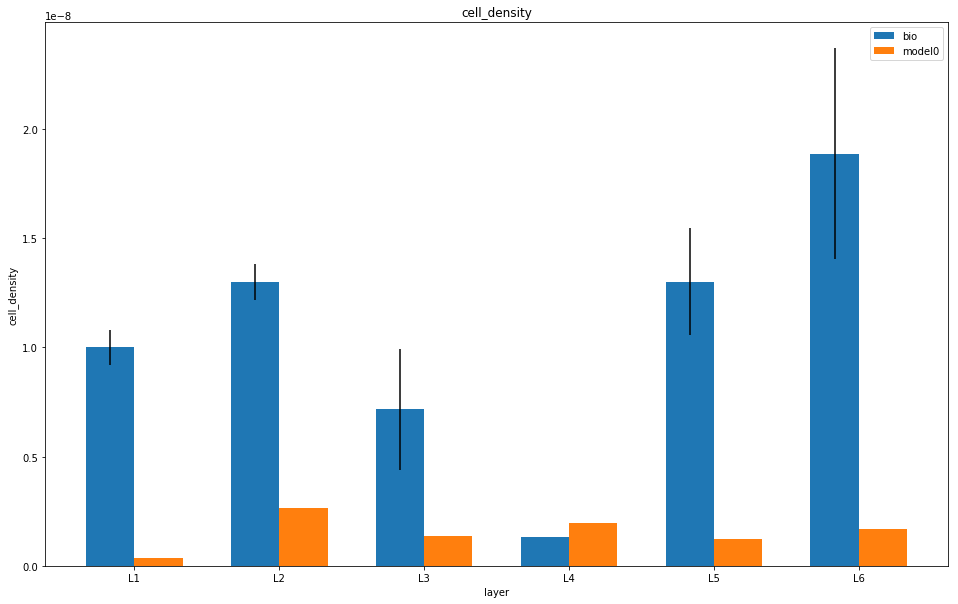

In [4]:
CellDensityValidation(data=example_cell_density_data)(circuit_model)

/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:185: UserWarning: model number 0, <neuro_dmt.library.users.hugo.adapters.O1Adapter object at 0x7f97a246aba8> does not have label
  .format(i, model))


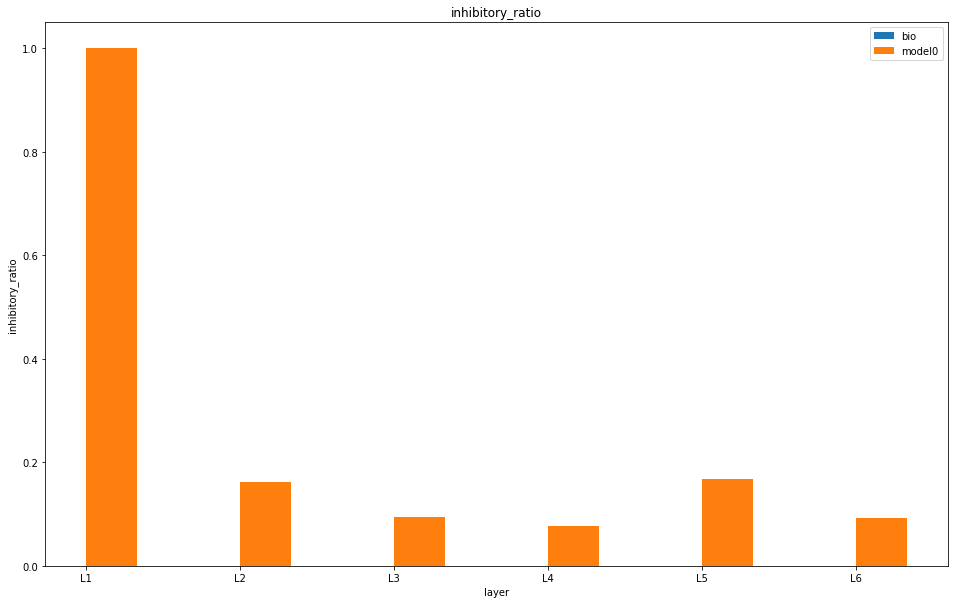

In [5]:
INHRatioValidation(data=pd.DataFrame([{'layer': l} for l in['L1', 'L2', 'L3', 'L4', 'L5', 'L6']]))\
                        (circuit_model)

In [6]:
# TODO: SynapseDensityValidation

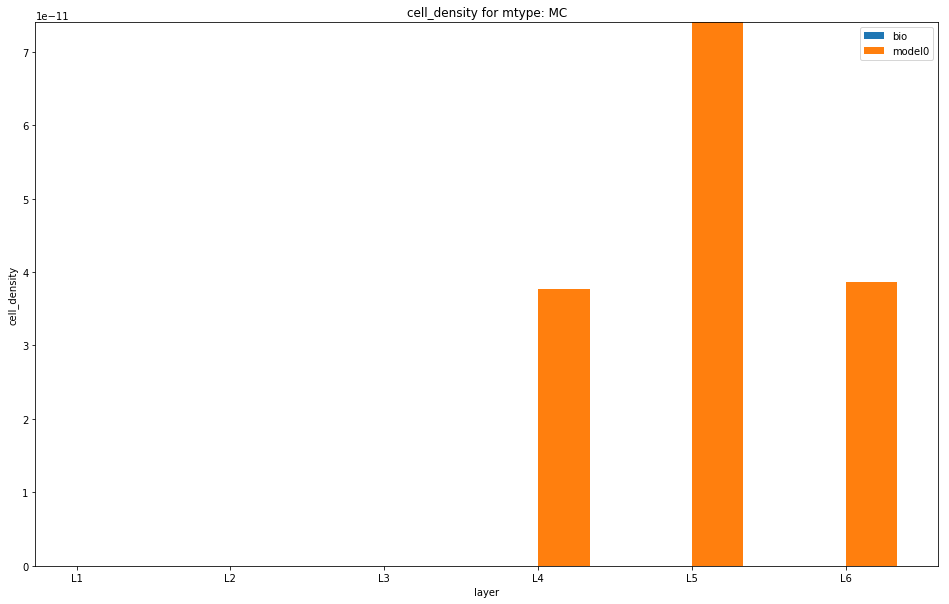

In [7]:
# automatically puts mtype in the title, rather than cluttering x-axis with repeated mentions
CellDensityValidation(data=pd.DataFrame([{'mtype': 'MC', 'layer': 'L{}'.format(l)} for l in range(1, 7)]))(circuit_model)

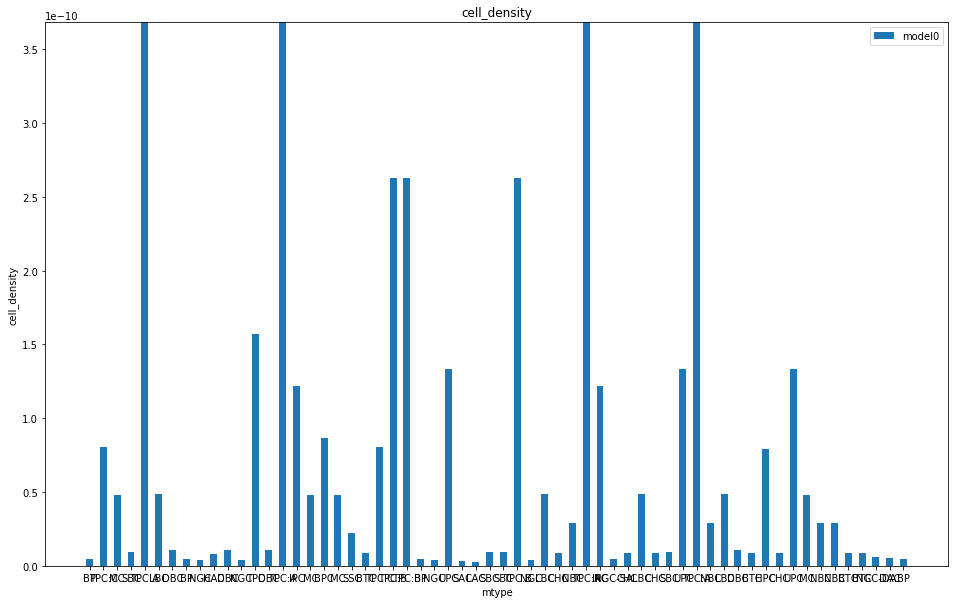

In [8]:
class CellDensityByMtypeValidation(CellDensityValidation):
    
    class AdapterInterface(CellDensityValidation.AdapterInterface):
        
        def mtypes(adapter_self):
            """
            get all the mtypes represented in the circuit
            They are expected as strings without laye prefixes
            """
            pass

    def by(self, model):
        return [{'mtype': mtype} for mtype in model.mtypes()]

CellDensityByMtypeValidation()(circuit_model)
        

/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:185: UserWarning: model number 1, <neuro_dmt.library.users.hugo.adapters.O1Adapter object at 0x7f9781a54550> does not have label
  .format(i, model))


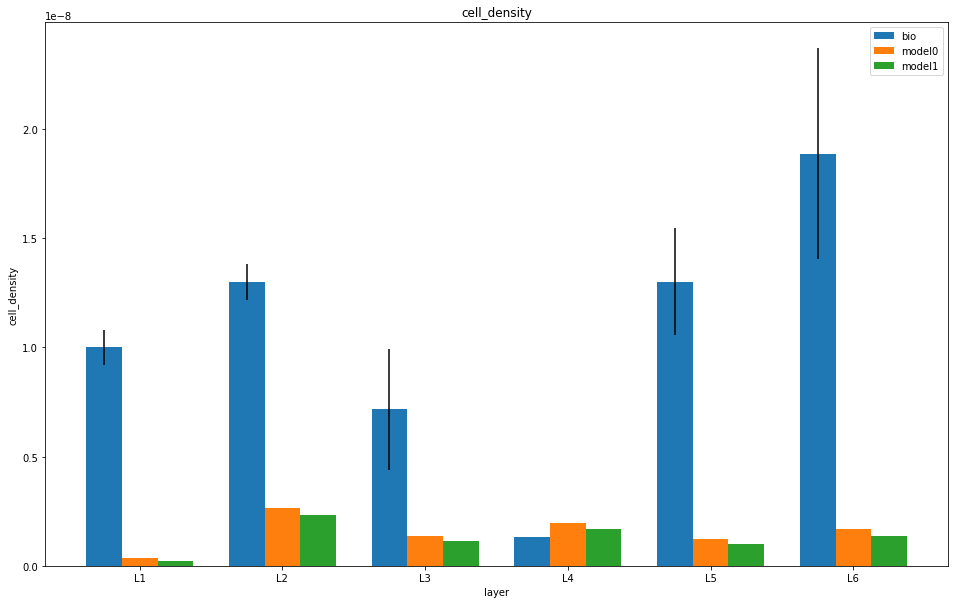

In [9]:
circuit_model_2 = O1Adapter("/gpfs/bbp.cscs.ch/project/proj66/circuits/O1/r0/CircuitConfig")
CellDensityValidation(data=example_cell_density_data)(circuit_model, circuit_model_2)

In [10]:
try:
    INHRatioValidation()
except AssertionError as E:
    print(E)

In [11]:
import numpy as np
class ActuallyAnAtlasAdapter():
    
    def __init__(self, atlas_dir):
        from voxcell.nexus.voxelbrain import Atlas
        self._atlas = Atlas.open(atlas_dir)
    
    def _mask_for_query(self, query):
        region_mask = self._atlas.get_region_mask(query.get("region", "@.*$")).raw
        if 'layer' in query:
            layer = self._atlas.get_region_mask(self._translate_layer(query['layer'])).raw
            return np.logical_and(region_mask, layer)
        return region_mask

    # TODO: compose
    #def _translate_layer(self, layer):
    #    """for now assume mc_<c>;<integerlayer> format"""
    #    # TODO: auto-detect on initialization?
    #    return "@L{}$".format(layer[1])
    def _translate_layer(self, layer):
        return "@;{}$".format(layer[1])
    
    # TODO: compose
    #def _cell_density_filename(self, extension):
    #    return extension
    def _cell_density_filename(self, extension):
         return '[cell_density]' + extension
    
    # TODO: compose
    def _density_types(self):
        import glob
        import os
        all_nrrds = glob.glob(os.path.join(self._atlas.dirpath, "*.nrrd"))
        all_nrrds = [os.path.basename(nrrd).split(".")[0] for nrrd in all_nrrds]
        all_nrrds = [nrrd.split("[cell_density]")[1] if nrrd.startswith("[cell_density]") else nrrd
                    for nrrd in all_nrrds]
        excluded = ['brain_regions', 'orientation', '[PH]y', 'height', 'distance', 'relative_distance', 'depth'] \
        + ['[PH]{}'.format(i) for i in range(1, 7)]\
        + ['thickness:L{}'.format(i) for i in range(1, 7)]\
        + ["EXC", "INH"]
        
        density_nrrds = [nrrd for nrrd in all_nrrds if nrrd not in excluded]
        return density_nrrds
    
    def cell_density(self, query):
        mask = self._mask_for_query(query)
        sclass = query.get('sclass', ['EXC', 'INH'])
        if isinstance(sclass, str):
            sclass = [sclass]
        density_types = self._density_types()
 
        return sum(
            self._atlas.load_data(self._cell_density_filename(dtype)).raw[mask] 
            for dtype in sclass)#density_types)
        

In [12]:
import yaml
DefilipeDatapath = "/gpfs/bbp.cscs.ch/project/proj64/dissemination/data/DeFelipe2017.yaml"
with open(DefilipeDatapath) as DFDF:
    DFDict = yaml.load(DFDF)
DFDict

{'age': 'P14-16',
 'animal': 'wistar rat',
 'brainArea': 'S1 hindlimb',
 'circuits': {'P14-12': {'densities': [17218,
    122006,
    75306,
    169828,
    90956,
    108090],
   'thicknesses': [122.3, 113.5, 302.9, 176.4, 477.9, 647.3]},
  'P14-13': {'densities': [7040, 169299, 81310, 172339, 71296, 111238],
   'thicknesses': [148.5, 121.7, 303.7, 159.2, 412.8, 627.1]},
  'P14-14': {'densities': [15337, 171045, 74956, 150973, 80783, 135638],
   'thicknesses': [160.5, 126.4, 303.8, 161.2, 442.6, 536.6]},
  'P14-15': {'densities': [17290, 162856, 78259, 178580, 84361, 134840],
   'thicknesses': [143.2, 135.4, 296.5, 160.9, 447.7, 603.5]},
  'P14-16': {'densities': [13190, 151972, 80528, 166547, 71168, 135599],
   'thicknesses': [146.6, 144.5, 319.7, 168.9, 486.9, 670.2]},
  'P14-17': {'densities': [9100, 167304, 76077, 149437, 68655, 106430],
   'thicknesses': [147.1, 141.9, 331.2, 171.2, 496.1, 601.8]}},
 'citation': "De Felipe et al. (2014 unpublished). 'Cell Counts per Layer', Unpub

In [13]:
import pandas as pd
DefilipeCellDensityData = pd.DataFrame({'layer':
                                        ["L1", "L2", "L3", "L4", "L5", "L6"],
                                       'samples': 
                                        [[subj['densities'][l] 
                                          for subj in DFDict['circuits'].values()]
                                         for l in range(6)]})
DefilipeCellDensityData

,layer,samples
0,L1,"[15337, 7040, 17218, 17290, 9100, 13190]"
1,L2,"[171045, 169299, 122006, 162856, 167304, 151972]"
2,L3,"[74956, 81310, 75306, 78259, 76077, 80528]"
3,L4,"[150973, 172339, 169828, 178580, 149437, 166547]"
4,L5,"[80783, 71296, 90956, 84361, 68655, 71168]"
5,L6,"[135638, 111238, 108090, 134840, 106430, 135599]"


In [14]:
rats_df =\
   pd.concat([
       pd.DataFrame(subject_data)\
         .assign(subject=subject_label)
       for subject_label, subject_data in DFDict['circuits'].items()])\
       .assign(layer=['L1', "L2", "L3", "L4", "L5", "L6"]*6).set_index("subject")\
       .rename(columns={"densities": "samples", "thicknesses": "thickness"})
print(rats_df.loc['P14-12'])
mean_rat = rats_df.groupby("layer").agg('mean')
print(mean_rat)
mean_rat['subject'] = "mean"
rats_df = pd.concat((rats_df, mean_rat.assign(subject="mean", layer=mean_rat.index).set_index("subject")))
print(rats_df)

         samples  thickness layer
subject                          
P14-12     17218      122.3    L1
P14-12    122006      113.5    L2
P14-12     75306      302.9    L3
P14-12    169828      176.4    L4
P14-12     90956      477.9    L5
P14-12    108090      647.3    L6
             samples   thickness
layer                           
L1      13195.833333  144.700000
L2     157413.666667  130.566667
L3      77739.333333  309.633333
L4     164617.333333  166.300000
L5      77869.833333  460.666667
L6     121972.500000  614.416667
               samples   thickness layer
subject                                 
P14-14    15337.000000  160.500000    L1
P14-14   171045.000000  126.400000    L2
P14-14    74956.000000  303.800000    L3
P14-14   150973.000000  161.200000    L4
P14-14    80783.000000  442.600000    L5
P14-14   135638.000000  536.600000    L6
P14-13     7040.000000  148.500000    L1
P14-13   169299.000000  121.700000    L2
P14-13    81310.000000  303.700000    L3
P14-13   1723

/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:185: UserWarning: model number 0, <__main__.ActuallyAnAtlasAdapter object at 0x7f97803d9390> does not have label
  .format(i, model))


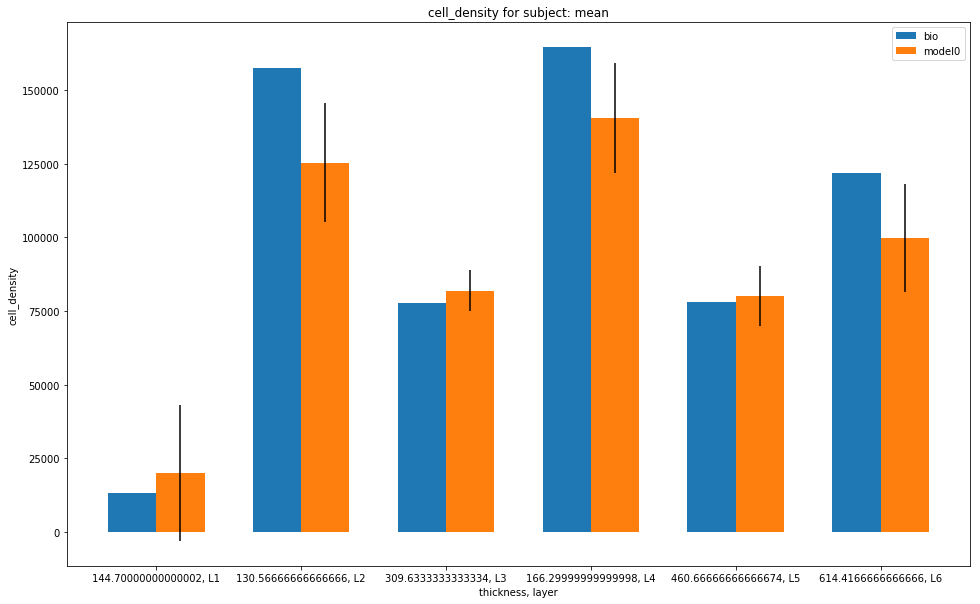

In [15]:
rat = "mean"
report = CellDensityValidation(data=rats_df.loc[rat].reset_index())(
    ActuallyAnAtlasAdapter("/gpfs/bbp.cscs.ch/project/proj64/dissemination/data/atlas/O1/DAN/"+rat))
    #ActuallyAnAtlasAdapter("/gpfs/bbp.cscs.ch/project/proj64/entities/dev/atlas/fixed_77831ACA-6198-4AA0-82EF-D0475A4E0647_01-06-2018"))

ImportError: cannot import name 'validate_rat_SSCX_cell_density_by_layer'

In [22]:
# test that CellDensityValidation's interface raises the right kind of error
class Amethodlessclass:
    pass
CellDensityValidation(data=example_cell_density_data)(Amethodlessclass())
# it doesn't work

/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:185: UserWarning: model number 0, <__main__.Amethodlessclass object at 0x7f97819c1320> does not have label
  .format(i, model))


AttributeError: 'Amethodlessclass' object has no attribute 'cell_density'

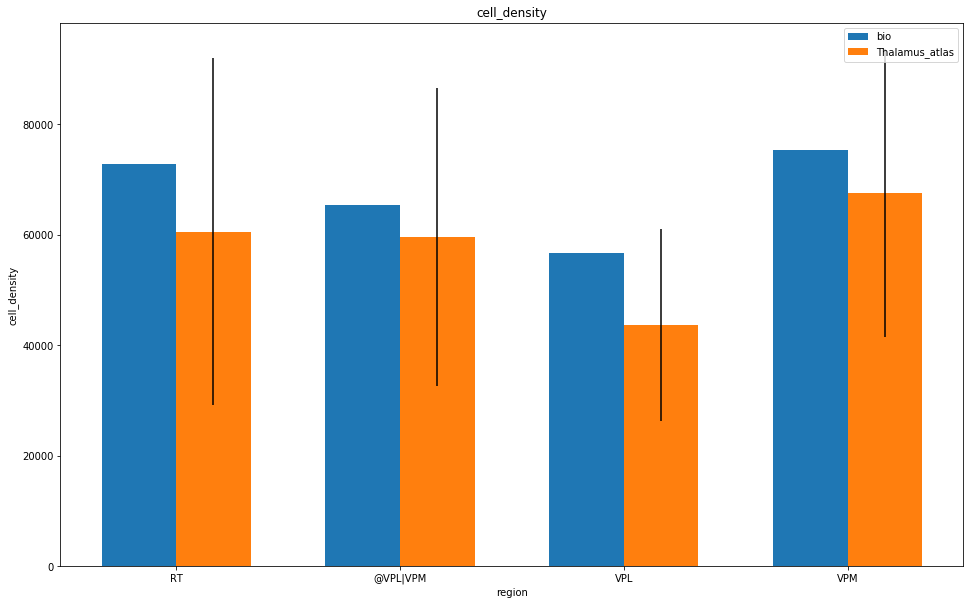

In [23]:
thal = ActuallyAnAtlasAdapter("/gpfs/bbp.cscs.ch/project/proj55/entities/atlas/20190628/")
ActuallyAnAtlasAdapter.label="Thalamus_atlas"
CellDensityValidation(data=pd.DataFrame({
    'samples' : [72802.84, 65364.87, 56678.06, 75391.47],
    'region': ['RT', '@VPL|VPM', 'VPL', 'VPM']
}))(thal)

# saved here for later use
from voxcell.nexus.voxelbrain import Atlas
atlas = Atlas.open("/gpfs/bbp.cscs.ch/project/proj64/dissemination/tools/sscxdis/data/atlas/O1/mean")
np.unique(atlas.load_data("[cell_density]EXC").raw)
import numpy as np
class ActuallyAnO1AtlasAdapter():
    
    def __init__(self, atlas_dir):
        from voxcell.nexus.voxelbrain import Atlas
        self._atlas = Atlas.open(atlas_dir)
    
    def _mask_for_query(self, query):
        queryacro = "@{}$".format(query.get('layer'))
        return self._atlas.get_region_mask(queryacro)

    def cell_density(self, query):
        mask = self._mask_for_query(query)
        return ((
            self._atlas.load_data("[cell_density]EXC").raw 
            + self._atlas.load_data("[cell_density]INH").raw)[mask.raw])
np.unique(atlas.load_data("[cell_density]EXC").raw)
ls /gpfs/bbp.cscs.ch/project/proj64/dissemination/tools/sscxdis/data/atlas/O1/mean
np.unique(atlas.load_data("[cell_density]EXC").raw[atlas.load_region_mask("L1").raw])
np.unique(atlas.load_data("[cell_density]EXC").raw[atlas.get_region_mask("L1").raw])
np.unique(atlas.load_data("[cell_density]EXC").raw[atlas.get_region_mask("@L1").raw])
y = atlas.load_data("[PH]y").raw
EXC = atlas.load_data("[cell_density]EXC").raw
plt.plot([EXC[y==uny] for uny in np.unique(y)])
import matplotlib.pyplot as plt
plt.plot([EXC[y==uny] for uny in np.unique(y)])
plt.show()
np.unique(y)
excbydepth = [EXC[y==uny] for uny in np.unique(y)]
excbydepth
excbydepth = [np.mean(EXC[y==uny]) for uny in np.unique(y)]
excbydepth
np.unique(y[atlas.load_data("brain_regions").raw == 0])
excbydepth = [EXC[y==uny] for uny in np.unique(y)]
anywhere = atlas.get_region_mask("O1").raw
excbydepth = [EXC[np.logical_and(y==uny, anywhere)] for uny in np.unique(y)]
excbydepth
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
excbydepth
ph1 = atlas.load_data("[PH]1").raw
ph1 = atlas.load_data("[PH]L1").raw
l1bydepth = [np.mean(ph1[0][np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
l1bydepth = [np.mean(ph1[...,0][np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
l1bydepth
ph1 = atlas.load_data("[PH]L4").raw
l1bydepth = [np.mean(ph1[...,0][np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
l1bydepth
EXC = atlas.load_data("[cell_density]EXC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
excbydepth
EXC = atlas.load_data("[cell_density]EXC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(excbydepth); plt.show()
plt.plot(np.unique(y), excbydepth); plt.show()
INH = atlas.load_data("[cell_density]INH").raw
inhbydepth = [np.mean(INH[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), excbydepth); plt.show()
plt.plot(np.unique(y), inhbydepth); plt.show()
plt.plot(np.unique(y), excbydepth); plt.show()
ph1 = atlas.load_data("[PH]L1").raw
ph1[...,0]
ph1[...,1]
ph1[...,2]
atlas.load_data("[PH]2").raw[...,1]
atlas.load_data("[PH]L2").raw[...,1]
atlas.load_data("[PH]L2").raw[...,0]
atlas.load_data("[PH]L2").raw[...,1]
atlas.load_data("[PH]L3").raw[...,1]
atlas.load_data("[PH]L4").raw[...,1]
atlas.load_data("[PH]L5").raw[...,1]
atlas.load_data("[PH]L6").raw[...,1]
atlas.load_data("[PH]L6").raw[...,1]
atlas.load_data("[PH]L6").raw[...,0]
plt.plot(np.unique(y), excbydepth); plt.show()
EXC = atlas.load_data("[cell_density]EXC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), excbydepth); plt.show()
atlas.load_data("[PH]L6").raw[...,1]
atlas.load_data("[PH]L6").raw[...,0]
atlas.load_data("[PH]L1").raw[...,0]
atlas.load_data("[PH]L6").raw[...,0]
EXC = atlas.load_data("[cell_density]EXC").raw
plt.plot(np.unique(y), excbydepth); plt.show()
EXC = atlas.load_data("[cell_density]EXC").raw
plt.plot(np.unique(y), excbydepth); plt.show()
EXC = atlas.load_data("[cell_density]EXC", cache=False).raw
EXC = atlas.load_data("[cell_density]EXC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), excbydepth); plt.show()
atlas = Atlas.open("/gpfs/bbp.cscs.ch/project/proj64/dissemination/tools/sscxdis/data/atlas/O1/P14-12")
EXC = atlas.load_data("[cell_density]EXC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), excbydepth); plt.show()
atlas = Atlas.open("/gpfs/bbp.cscs.ch/project/proj64/dissemination/tools/sscxdis/data/atlas/O1/mean")
EXC = atlas.load_data("[cell_density]EXC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), excbydepth); plt.show()
EXC = atlas.load_data("[cell_density]EXC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), excbydepth); plt.show()
EXC = atlas.load_data("[cell_density]EXC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), excbydepth); plt.show()
EXC = atlas.load_data("[cell_density]L5_MC").raw
excbydepth = [np.mean(EXC[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), excbydepth); plt.show()
import glob
denses = glob.glob(atlas.dirpath)
denses
denses = glob.glob(atlas.dirpath + "/[cell_density]L*")
denses
denses = glob.glob(atlas.dirpath + "/[cell_density]EXC.nrrd")
denses
from os.path import join
denses = glob.glob(join(atlas.dirpath, "[cell_density]L*"))
denses
join(atlas.dirpath, "[cell_density]L*.nrrd")
glob.glob(join(atlas.dirpath, "[cell_density]L*.nrrd"))
glob.glob(join(atlas.dirpath, "*"))
glob.glob(join(atlas.dirpath, "\[cell_density\]L*"))
glob.glob(join(atlas.dirpath, "[cell_density]*"))
glob.glob(join(atlas.dirpath, "*.nrrd"))
glob.glob(join(atlas.dirpath, "L*.nrrd"))
glob.glob(join(atlas.dirpath, "*L*.nrrd"))
denses = glob.glob(join(atlas.dirpath, "L*.nrrd"))
denses
glob.glob(join(atlas.dirpath, "L*.nrrd"))
denses = [splittext(basename(d)) for d in glob.glob(join(atlas.dirpath, "*L*.nrrd"))]
from os.path import splitext, basename
denses = [splitext(basename(d)) for d in glob.glob(join(atlas.dirpath, "*L*.nrrd"))]
denses
denses = [splitext(basename(d))[0] for d in glob.glob(join(atlas.dirpath, "*L*.nrrd"))]
denses
sumalldens = np.sum([atlas.load_data(d).raw for d in denses], axis=0)
denses
denses = [splitext(basename(d))[0] for d in glob.glob(join(atlas.dirpath, "*L*_*.nrrd"))]
denses
sumalldens = np.sum([atlas.load_data(d).raw for d in denses], axis=0)
sdensbydepth = [np.mean(sumalldens[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), sdensbydepth); plt.show()
sdensbydepth = [np.mean(sumalldens[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
sumalldens = np.sum([atlas.load_data(d).raw for d in denses], axis=0)
sdensbydepth = [np.mean(sumalldens[np.logical_and(y==uny, anywhere)]) for uny in np.unique(y)]
plt.plot(np.unique(y), sdensbydepth); plt.show()
history
